# Выделение аспекта "Развитие промышленности" в корпусе предложений предвыборной агитации на русском языке
## Выполнили: Дрозд Елена, Колупаев Егор, Савостиков Михаил

Целью данной работы было рассмотреть методы бинарной классификации для текстов на русском языке.
Были рассмотрены эмбеддинги для русского языка (методы преобразования объектов в чесленный вектор), предобученные на разных текстах.
Также в данной работе были использованы разные методы предобработки текстов (лемматизация, стемминг и т.д.).
Использовалось как усреднение векторов слов для получения вектора предложения, так и методы lstm.
Также использовалось несколько классификаторов, описанных далее в работе.
Метрикой использовалась f1-мера, а для лучшей оценки качества проведенных экспериментов использовалась кросс-валидация.

In [1]:
import csv
from datetime import datetime
from functools import partial
from itertools import product
import numpy as np
import pandas as pd
from keras._tf_keras import keras
from navec import Navec
from scipy.stats import gmean
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from keras import Sequential
from keras.src.layers import Embedding
import tensorflow as tf
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

2025-06-08 22:34:20.578516: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 22:34:20.582228: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 22:34:20.592534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749411260.610596   41543 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749411260.615712   41543 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749411260.629160   41543 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
def load_file(file):
    data = pd.read_csv(file)
    sentences = data['sentence']
    aspects = data.iloc[:, [7]]
    return sentences, aspects


def load_files(*files):
    return list(map(lambda x: pd.concat(x, ignore_index=True),
                    zip(*[load_file(file) for file in files])))

Загрузка корпусов текстов. Разбиваем на предложения и метки.
Корпус предложений из материалов предвыборной агитации на русском языке
В самом корпусе раставлено 10 разных меток, соответствующих разным аспектам, упоминаемым в этих предложениях.
Данную работу можно применить для любого аспекта, но сейчас рассматривался только аспект "развитие промышленности", 
Так как это самый встречаемый аспект в корпусе ( 317 из 2043 в первоначальном корпусе, 618 из 3394 предложений в дополненном.

In [3]:
# Первоначальный корпус
sentences, aspect_marks = load_files(
                                      "data/aspects-marked-part-2-elections-1.csv",
                                      "data/aspects-marked-part-2-elections-2.csv",
                                      )

print(f"соотношение меток для первоначального корпуса {np.unique(aspect_marks, return_counts=True)}")
print(sentences[:5])

# Дополненный корпус
all_sentences, all_aspect_marks = load_files(
                                      "data/aspects-marked-part-2-elections-1.csv",
                                      "data/aspects-marked-part-2-elections-2.csv",
                                      "data/aspects-marked-part-2-elections-3.csv"
                                      )
print(f"соотношение меток для дополненного корпуса {np.unique(all_aspect_marks, return_counts=True)}")

(array([0, 1]), array([1726,  317]))
0    «Подобные встречи, — говорит Евгений Николаеви...
1    «Старская земля: Возрождение 2010—2015» — это ...
2    10 октября 2010 года в городе Кузнецк пройдут ...
3    10 октября 2010 года состоятся выборы в Думу и...
4    30 июля наш регион получил лицензию на предпро...
Name: sentence, dtype: object
(array([0, 1]), array([2776,  618]))


Посчитаем среднее количество слов в предложении и среднюю длину слова

In [42]:
def calculate_averages(sentences):
    total_words = 0
    total_word_length = 0
    
    # Если sentences — это pandas.Series или numpy.ndarray, преобразуем в список
    sentences_list = list(sentences) if hasattr(sentences, '__iter__') and not isinstance(sentences, str) else [sentences]
    
    for sentence in sentences_list:
        if isinstance(sentence, str):  # Проверяем, что элемент — строка
            words = sentence.split()
            total_words += len(words)
            total_word_length += sum(len(word) for word in words)
    
    average_word_count = total_words / len(sentences_list) if len(sentences_list) > 0 else 0
    average_word_length = total_word_length / total_words if total_words > 0 else 0
    
    return average_word_count, average_word_length

avg_count, avg_length = calculate_averages(all_sentences.values)

print(f"Среднее количество слов в предложении: {avg_count:.2f}")
print(f"Средняя длина слова: {avg_length:.2f} символов")

Среднее количество слов в предложении: 18.36
Средняя длина слова: 6.88 символов



Предобработка текстов

Загрузка стоп-слов из NLTK

In [4]:
download('stopwords')  # Скачивает список стоп-слов (требуется только при первом запуске)
russian_stopwords = set(stopwords.words('russian'))  # Загружаем русские стоп-слова в множество для быстрого поиска

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/egorkokupaev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Инициализация компонентов для обработки русского языка

In [5]:
segmenter = Segmenter()  # Для разделения текста на токены (слова)
morph_vocab = MorphVocab()  # Морфологический словарь для лемматизации
emb = NewsEmbedding()  # Предобученные эмбеддинги для русского языка
morph_tagger = NewsMorphTagger(emb)  # Морфологический таггер (определение частей речи)
stemmer = SnowballStemmer("russian")  # Стеммер для приведения слов к основе

Проверяет, является ли слово стоп-словом.
Возвращает True, если:
1) слово состоит из не-буквенных символов (знаки препинания, спецсимволы)
2) слово присутствует в списке стоп-слов NLTK (в нижнем регистре)

In [6]:
def is_stopword(word):
    if not re.match(r'^\w+$', word):  # Проверяем, что слово состоит только из букв/цифр
        return True
    if word.lower() in russian_stopwords:  # Проверяем наличие в списке стоп-слов
        return True
    return False

Заменяет числовые токены на метку [digits].
    Сохраняет токены, состоящие только из букв.

In [7]:
def replace_numbers(token):
    if re.match(r'[А-яЁёA-z]+', token):  # Если токен состоит только из букв
        return token
    if re.search(r'[\d+.,]+', token) is not None:  # Если содержит цифры/точки/запятые
        return "[digits]"
    return token  # Возвращает исходный токен для остальных случаев

Проверяет, содержит ли токен числовые значения

In [8]:
def is_number(token):
    return re.search(r'[\d+.,]+', token) is not None

Приводит слово к его основе (стемматизация)

In [9]:
def stem_token(token):
    return stemmer.stem(token)

Основная функция предобработки текста.
Параметры:
1) sentence: входное предложение для обработки
2) lemmatize: если True, использовать лемматизацию вместо исходных слов
3) stem_words: если True, применять стемматизацию
4) drop_digits: если True, удалять числовые токены
    
Возвращает список обработанных токенов.

In [10]:
def preprocess_sentence(sentence,
                       lemmatize=False,
                       stem_words=False,
                       drop_digits=True):

    # Создаем документ и применяем морфологический анализ
    doc = Doc(sentence)
    doc.segment(segmenter)  # Разбиваем на токены
    doc.tag_morph(morph_tagger)  # Определяем морфологические характеристики
    
    # Лемматизация каждого токена
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    # Выбираем леммы или исходные слова в зависимости от параметра
    if lemmatize:
        tokens = [token.lemma for token in doc.tokens]
    else:
        tokens = [token.text for token in doc.tokens]
    
    # Фильтрация токенов
    tokens = [token for token in tokens if not is_stopword(token)]  # Удаление стоп-слов
    
    # Дополнительная обработка
    if stem_words:  # Стемматизация
        tokens = [stem_token(token) for token in tokens]
    
    # Обработка чисел
    if drop_digits:  # Удаление чисел
        tokens = [token for token in tokens if not is_number(token)]
    else:  # Замена чисел на метку
        tokens = [replace_numbers(token) for token in tokens]
    
    return tokens

Объевляем модели эмбеддингов для преобразования текстов в числовой вектор
В данной работе использовался Navec (основанный на GloVe) длины 300 из состава проекта Natasha.
Использовались два варианта: обученный на текстах художественной литературы и обученный на новостных текстах.
Подробнее: https://natasha.github.io/navec

In [11]:
models = [
          'models/navec_hudlit_v1_12B_500K_300d_100q.tar',
          'models/navec_news_v1_1B_250K_300d_100q.tar'
          ]

model_navec_hudlit = Navec.load(models[0])
model_navec_news = Navec.load(models[1])

Получение эмбеддинга предложения усреднением эмбэддинга слов

In [12]:
def apply_navec(sentence, model_):
    unk = model_['<unk>']
    words_matrix = np.array([model_.get(word, unk) for word in sentence])
    word = words_matrix.mean(axis=0)
    return word

Получение эмбеддинга предложения прогоном эмбеддинга слов через слой lstm
Гиперпараметры: размер выходного вектора, коэффицент dropout
LSTM (Long Short-Term Memory) — это тип рекуррентной нейронной сети (RNN), предназначенный для работы с последовательностями данных. В отличие от обычных RNN, LSTM умеет "запоминать" долгосрочные зависимости, избегая проблемы исчезающего градиента
Dropout — это метод регуляризации, который случайным образом "отключает" часть нейронов во время обучения, предотвращая переобучение.

In [34]:
lstm = keras.layers.LSTM(512, dropout=0.2, recurrent_dropout=0.2)
def apply_navec_with_lstm(sentence, model_):
    unk = model_['<unk>']
    words_matrix = np.array([model_.get(word, unk) for word in sentence])
    words_vectors = []
    words_vectors.append(words_matrix)
    words_vectors = np.array(words_vectors)
    output = lstm(words_vectors)
    words_vectors_lstm = np.array(output[0])
    return words_vectors_lstm

Начнем эксперименты с того, что возьмем первоначальный корпус текстов и приведем предложения в векторный вид:
1) Модель navec, обученная на художественной литературе, предварительно к словам применена лемматизация; 
2) Модель navec, обученная на художественной литературе, предварительно к словам применен стемминг; 
3) Модель navec, обученная на новостях, предварительно к словам применена лемматизация;  
4) Модель navec, обученная на новостях, предварительно к словам применен стемминг. 

In [14]:
sentence_lemm_navec_hudlib_mean = np.array([apply_navec(preprocess_sentence(sentence=sentence, lemmatize=True, stem_words=False, drop_digits=True), model_navec_hudlit) for sentence in sentences])
print("sentence_lemm_navec_hudlib_mean is done")
sentence_stem_navec_hudlib_mean = np.array([apply_navec(preprocess_sentence(sentence=sentence, lemmatize=False, stem_words=True, drop_digits=True), model_navec_hudlit) for sentence in sentences])
print("sentence_stem_navec_hudlib_mean is done")
sentence_lemm_navec_news_mean = np.array([apply_navec(preprocess_sentence(sentence=sentence, lemmatize=True, stem_words=False, drop_digits=True), model_navec_news) for sentence in sentences])
print("sentence_lemm_navec_news_mean is done")
sentence_stem_navec_news_mean = np.array([apply_navec(preprocess_sentence(sentence=sentence, lemmatize=False, stem_words=True, drop_digits=True), model_navec_news) for sentence in sentences])
print("sentence_stem_navec_news_mean is done")

sentence_lemm_navec_hudlib_mean is done
sentence_stem_navec_hudlib_mean is done
sentence_lemm_navec_news_mean is done
sentence_stem_navec_news_mean is done


Для визуализации полученных данных используем PCA (Principal Component Analysis) для снижения размерности

In [15]:
def visualization(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Визуализация
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Классы')
    plt.title('PCA визуализация векторов в 2D')
    plt.xlabel('Первая главная компонента (PC1)')
    plt.ylabel('Вторая главная компонента (PC2)')
    plt.grid(True)
    plt.show()

Визуализация ранее описанных подходов.
Из этих графиков уже сразу видно, что при стемминге предложения сильно перемешаны, а при использовании лемматизации визуально присутствует разбиение на две кучки

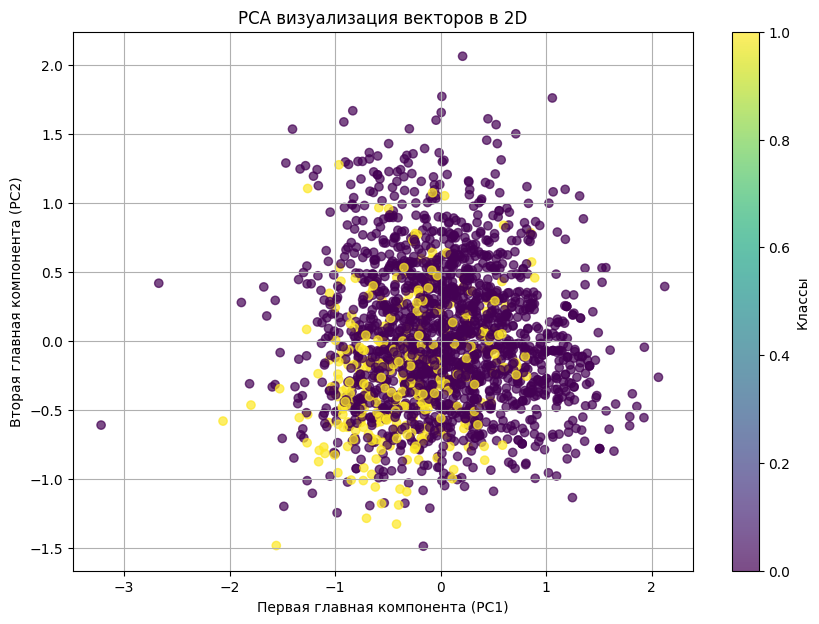

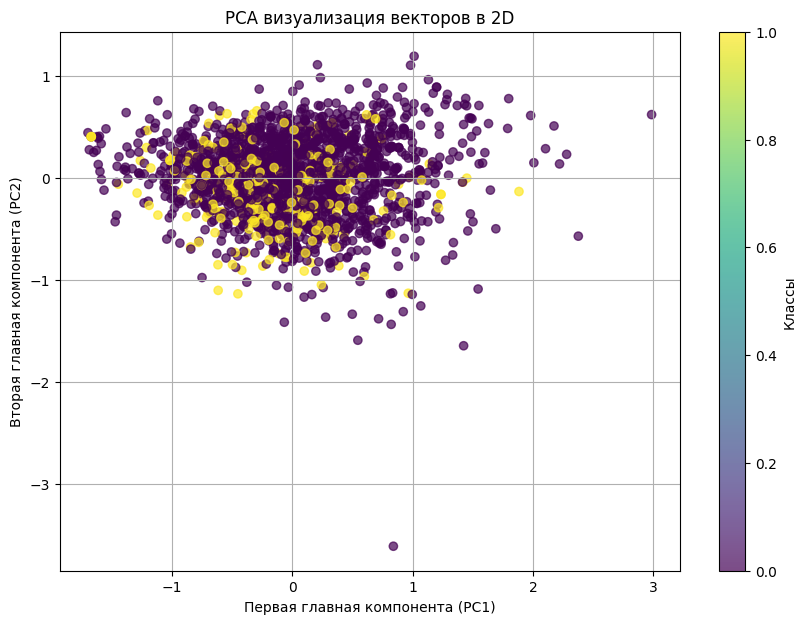

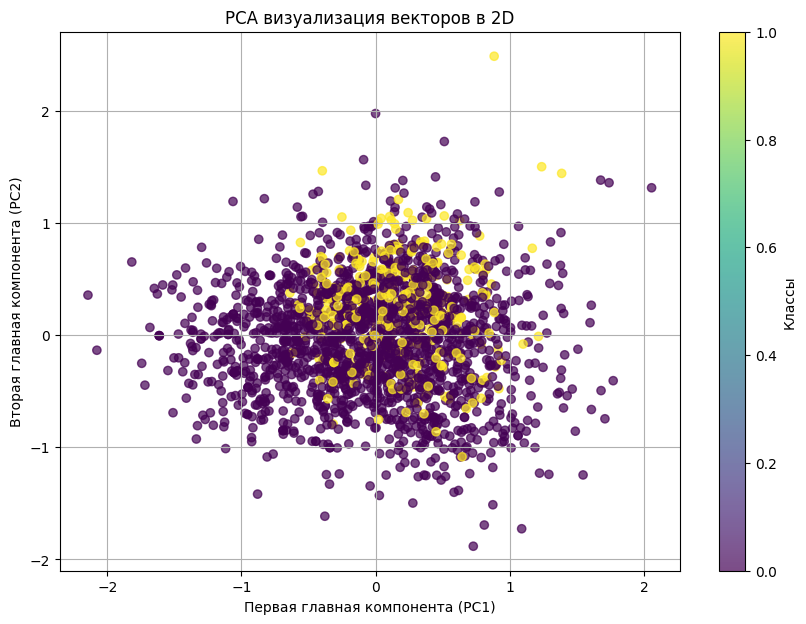

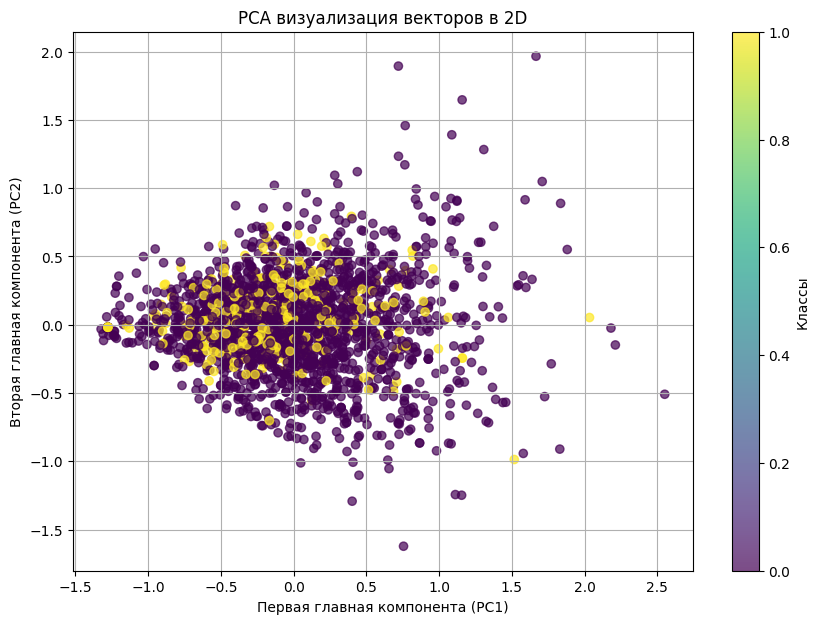

In [16]:
visualization(sentence_lemm_navec_hudlib_mean, aspect_marks.values)
visualization(sentence_stem_navec_hudlib_mean, aspect_marks.values)
visualization(sentence_lemm_navec_news_mean, aspect_marks.values)
visualization(sentence_stem_navec_news_mean, aspect_marks.values)

Объявляем используемы классификаторы
1) LogisticRegression: Использует логистическую функцию (sigmoid) для предсказания вероятности класса.
2) SVC: Строит гиперплоскость в пространстве высокой размерности
3) RandomForestClassifier с разной глубиной: cтроит множество деревьев, каждое на случайном подмножестве данных/признаков.

In [17]:
classifiers_builders = [
    lambda: LogisticRegression(class_weight="balanced"),
    lambda: SVC(class_weight="balanced", random_state=42),
    lambda: RandomForestClassifier(class_weight="balanced", random_state=42, max_depth=3),
    lambda: RandomForestClassifier(class_weight="balanced", random_state=42, max_depth=7),
    lambda: RandomForestClassifier(class_weight="balanced", random_state=42, max_depth=10),
]

Будет использована метрика F1.
    Так как F1-score — это гармоническое среднее между precision (точностью) и recall (полнотой).
Она особенно полезна в задачах с несбалансированными классами, где accuracy (доля правильных ответов) может вводить в заблуждение.

In [18]:
# model, best_prec, bast_recall, best_f1
# Для хранения лучших результатов каждого классификатора по отдельности
best_model = [["", 0, 0, 0, []], ["", 0, 0, 0, []], ["", 0, 0, 0, []], ["", 0, 0, 0, []], ["", 0, 0, 0, []]] 
# для хранения лучших результатов для каждой модели
all_result = []

Обучение кассификаторов и получение предсказаний.
Для лучшей оценки результатов будем использовать кросс-валидацию (n = 5)

In [19]:
def run_experiment(X, marks, model_path):
    i = 0
    best_classifer = ["", 0, 0, 0, []]
    for classifier_ in classifiers_builders:
        result_console = []
        classifier = classifier_()
        result_console.append(f"{model_path} {classifier.__class__}")
        f1_scores, precisions, recalls = [], [], []
        for aspect in marks.columns:
            y = marks[aspect].values.ravel()
            y_pred = np.array([0] * y.shape[0])
            y_train_pred = np.array([0] * y.shape[0])
            for train_ix, test_ix in StratifiedKFold(n_splits=5).split(X, y):
                X_train, X_test, y_train, y_test = X[train_ix], X[test_ix], y[train_ix], y[test_ix]
                clf = classifier
                clf.fit(X_train, y_train)
                y_train_out = clf.predict(X_train)
                y_test_out = clf.predict(X_test)
                y_train_pred[train_ix] = y_train_out
                y_pred[test_ix] = y_test_out
            prec, rec, f1, support = [_[0] for _ in precision_recall_fscore_support(y, y_pred, labels=[1])]
            train_f1 = f1_score(y, y_train_pred, labels=[1])
            f1_scores.append(f1)
            precisions.append(prec)
            recalls.append(rec)
            result_console.append(f"Упоминание аспекта '{aspect:30}' ({support:3}): "
                f"precision {prec:.2f}, recall {rec:.2f}, F1 {f1:.2f} (при обучении {train_f1:.2f})\n")
        if best_classifer[3] < f1:
            best_classifer[1] = prec
            best_classifer[2] = rec
            best_classifer[3] = f1
            best_classifer[0] = result_console[0]  
            best_classifer[4] = y_pred
        if best_model[i][3] < f1:
            best_model[i][1] = prec
            best_model[i][2] = rec
            best_model[i][3] = f1
            best_model[i][0] = result_console[0]
            best_model[i][4] = y_pred
        i = i + 1
    all_result.append(best_classifer)
        # print(result_console[0])
        # print(result_console[1])

Проведем эксперименты для моделей, в которых векторы предложений плучены усреднением векторов слов.
Ключевые результаты:
1) Как и ожидалось в моделях, где использовался стемминг, результаты очень низкие (далее в работе использоваться не будет)
2) В экспериментах, в которых эмбеддинги были построены с помощью navec, обученного на новостях, f-мера выше.
3) Лучше всего справлялся классификатор SVC

In [20]:
print(len(sentence_lemm_navec_hudlib_mean), len(aspect_marks))
run_experiment(sentence_lemm_navec_hudlib_mean, aspect_marks, "sentence_lemm_navec_hudlib_mean")
run_experiment(sentence_stem_navec_hudlib_mean, aspect_marks, "sentence_stem_navec_hudlib_mean")
run_experiment(sentence_lemm_navec_news_mean, aspect_marks, "sentence_lemm_navec_news_mean")
run_experiment(sentence_stem_navec_news_mean, aspect_marks, "sentence_stem_navec_news_mean")
for i in best_model:
    print(i[0])
    print(f"prec: {i[1]:.2f}, recall: {i[2]:.2f}, f1: {i[3]:.2f}") 
print()
for i in all_result:
    print(i[0])
    print(f"prec: {i[1]:.2f}, recall: {i[2]:.2f}, f1: {i[3]:.2f}")

2043 2043
sentence_lemm_navec_news_mean <class 'sklearn.linear_model._logistic.LogisticRegression'>
prec: 0.76, recall: 0.90, f1: 0.82
sentence_lemm_navec_news_mean <class 'sklearn.svm._classes.SVC'>
prec: 0.82, recall: 0.90, f1: 0.86
sentence_lemm_navec_news_mean <class 'sklearn.ensemble._forest.RandomForestClassifier'>
prec: 0.70, recall: 0.79, f1: 0.75
sentence_lemm_navec_hudlib_mean <class 'sklearn.ensemble._forest.RandomForestClassifier'>
prec: 0.80, recall: 0.54, f1: 0.65
sentence_lemm_navec_news_mean <class 'sklearn.ensemble._forest.RandomForestClassifier'>
prec: 0.90, recall: 0.40, f1: 0.55

sentence_lemm_navec_hudlib_mean <class 'sklearn.svm._classes.SVC'>
prec: 0.79, recall: 0.88, f1: 0.83
sentence_stem_navec_hudlib_mean <class 'sklearn.linear_model._logistic.LogisticRegression'>
prec: 0.39, recall: 0.71, f1: 0.50
sentence_lemm_navec_news_mean <class 'sklearn.svm._classes.SVC'>
prec: 0.82, recall: 0.90, f1: 0.86
sentence_stem_navec_news_mean <class 'sklearn.svm._classes.SVC'>

Визуализируем предсказание лучшего результата

In [21]:
y_pred_best = best_model[1][4]

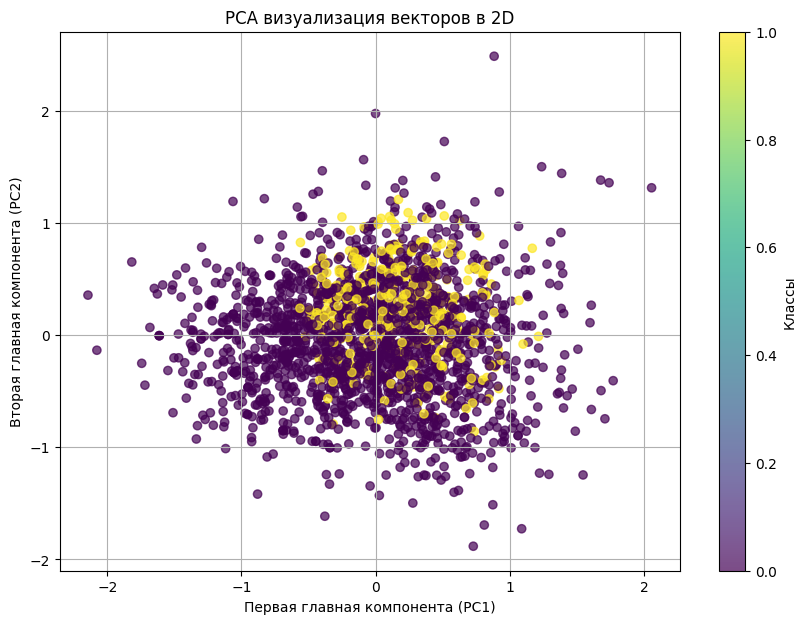

In [22]:
visualization(sentence_lemm_navec_news_mean, y_pred_best)

Теперь построим эмбеддинги для дополненного словаря. В этот раз не будем использовать cтемминг.

In [23]:
all_sentence_lemm_navec_hudlib_mean = np.array([apply_navec(preprocess_sentence(sentence=sentence, lemmatize=True, stem_words=False, drop_digits=True), model_navec_hudlit) for sentence in all_sentences])
print("all_sentence_lemm_navec_hudlib_mean is done")
all_sentence_lemm_navec_news_mean = np.array([apply_navec(preprocess_sentence(sentence=sentence, lemmatize=True, stem_words=False, drop_digits=True), model_navec_news) for sentence in all_sentences])
print("all_sentence_lemm_navec_news_mean is done")

all_sentence_lemm_navec_hudlib_mean is done
all_sentence_lemm_navec_news_mean is done


Теперь проведем эксперименты.
Результаты:
1) SVC опять справился лучше;
2) Результаты лучше с navec, обученным на новостях. Далее будем использовать его для экспериментов с lstm

In [24]:
run_experiment(all_sentence_lemm_navec_hudlib_mean, all_aspect_marks, "all_sentence_lemm_navec_hudlib_mean")
run_experiment(all_sentence_lemm_navec_news_mean, all_aspect_marks, "all_sentence_lemm_navec_news_mean")
for i in all_result[-2:]:
    print(i[0])
    print(f"prec: {i[1]:.2f}, recall: {i[2]:.2f}, f1: {i[3]:.2f}")

all_sentence_lemm_navec_hudlib_mean <class 'sklearn.svm._classes.SVC'>
prec: 0.84, recall: 0.92, f1: 0.88
all_sentence_lemm_navec_news_mean <class 'sklearn.svm._classes.SVC'>
prec: 0.87, recall: 0.94, f1: 0.90


По результатам по каждому классификатору видно, что логическая регрессия тоже хорошо справляется.

In [25]:
for i in best_model:
    print(i[0])
    print(f"prec: {i[1]:.2f}, recall: {i[2]:.2f}, f1: {i[3]:.2f}") 
print()

all_sentence_lemm_navec_news_mean <class 'sklearn.linear_model._logistic.LogisticRegression'>
prec: 0.81, recall: 0.94, f1: 0.87
all_sentence_lemm_navec_news_mean <class 'sklearn.svm._classes.SVC'>
prec: 0.87, recall: 0.94, f1: 0.90
all_sentence_lemm_navec_news_mean <class 'sklearn.ensemble._forest.RandomForestClassifier'>
prec: 0.70, recall: 0.84, f1: 0.76
all_sentence_lemm_navec_news_mean <class 'sklearn.ensemble._forest.RandomForestClassifier'>
prec: 0.89, recall: 0.71, f1: 0.79
all_sentence_lemm_navec_hudlib_mean <class 'sklearn.ensemble._forest.RandomForestClassifier'>
prec: 0.92, recall: 0.58, f1: 0.71



Визуализируем сначала изначальну разметку для лучшей модели

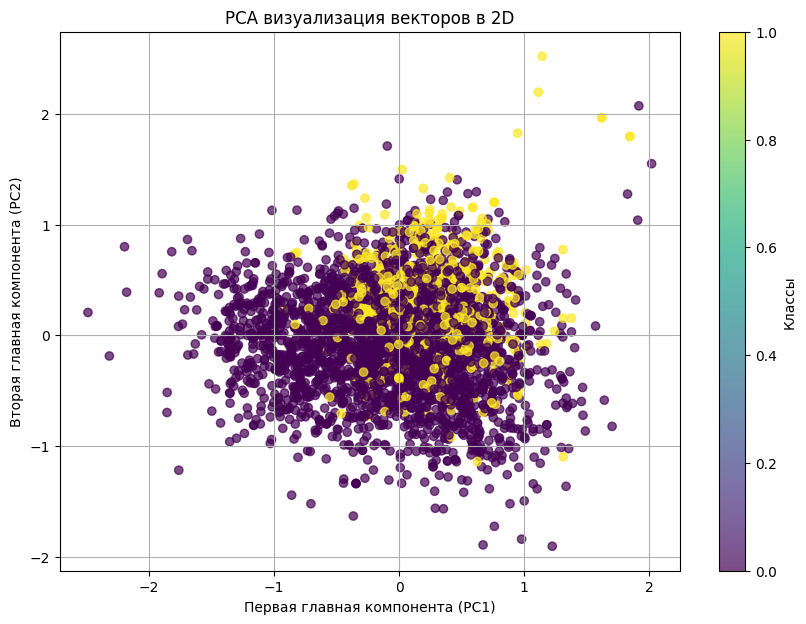

In [26]:
visualization(all_sentence_lemm_navec_news_mean, all_aspect_marks.values)

Теперь визуализируем предсказание

In [27]:
y_pred_best = best_model[1][4]

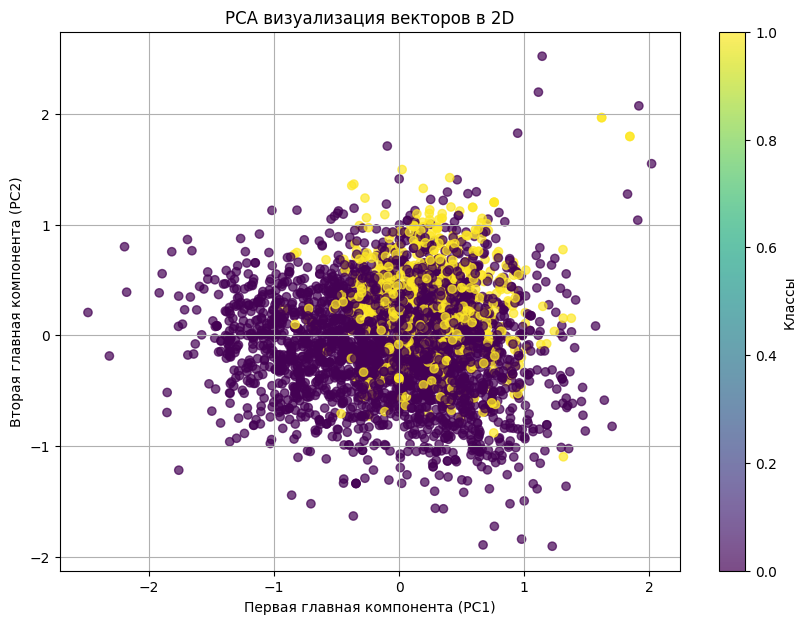

In [28]:
visualization(all_sentence_lemm_navec_news_mean, y_pred_best)

Теперь проведем эксперименты с lstm. Для начала возьмем lstm_size = 512 и dropout = 0.2

In [36]:
all_sentence_lemm_navec_news_lstm = np.array([apply_navec_with_lstm(preprocess_sentence(sentence=sentence, lemmatize=True, stem_words=False, drop_digits=True), model_navec_news) for sentence in all_sentences])
print("all_sentence_lemm_navec_news_lstm is done")

all_sentence_lemm_navec_news_lstm is done


Визуализируем изначальную разметку.

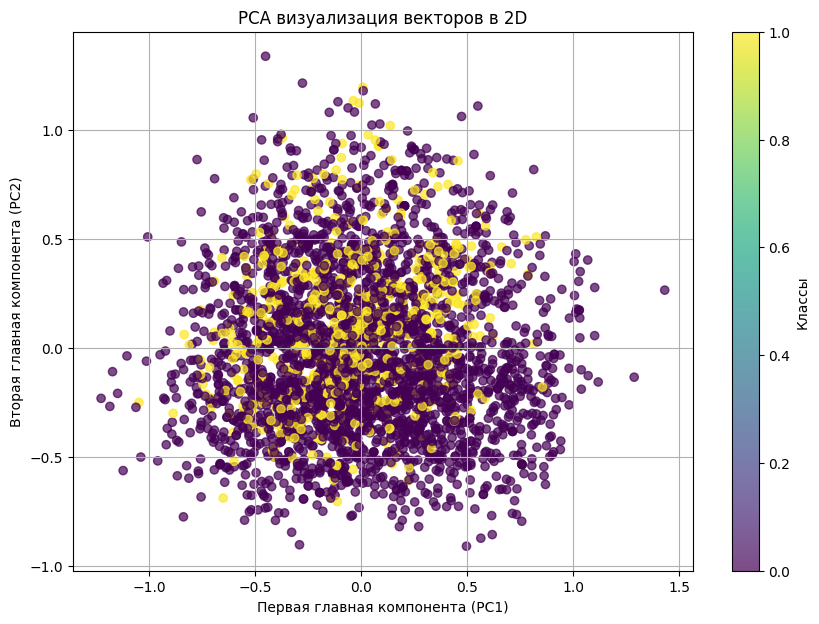

In [37]:
visualization(all_sentence_lemm_navec_news_lstm, all_aspect_marks.values)

Проведем эксперименты с использованием lstm. Результаты получились явно хуже.

In [38]:
run_experiment(all_sentence_lemm_navec_news_lstm, all_aspect_marks, "all_sentence_lemm_navec_news_lstm")
for i in all_result[-1:]:
    print(i[0])
    print(f"prec: {i[1]:.2f}, recall: {i[2]:.2f}, f1: {i[3]:.2f}")

all_sentence_lemm_navec_news_lstm <class 'sklearn.svm._classes.SVC'>
prec: 0.79, recall: 0.80, f1: 0.80


Заключение:
Лучшие результаты были получены при:
1) navec, обученном на новостях;
2) использовании лемматизации.

При увеличении размера корпуса сильно увеличивается качество результатов.
Использование lstm не привело к росту качества, а наоборот к ухудшению.

Лучший результат:
all_sentence_lemm_navec_news_mean <class 'sklearn.svm._classes.SVC'>
prec: 0.87, recall: 0.94, f1: 0.90